In [1]:
import pandas as pd

df = pd.read_csv(
    'https://raw.githubusercontent.com/rasbt/'
    'python-machine-learning-book-2nd-edition'
    '/master/code/ch10/housing.data.txt',
    header=None,
    sep='\s+')

df.columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


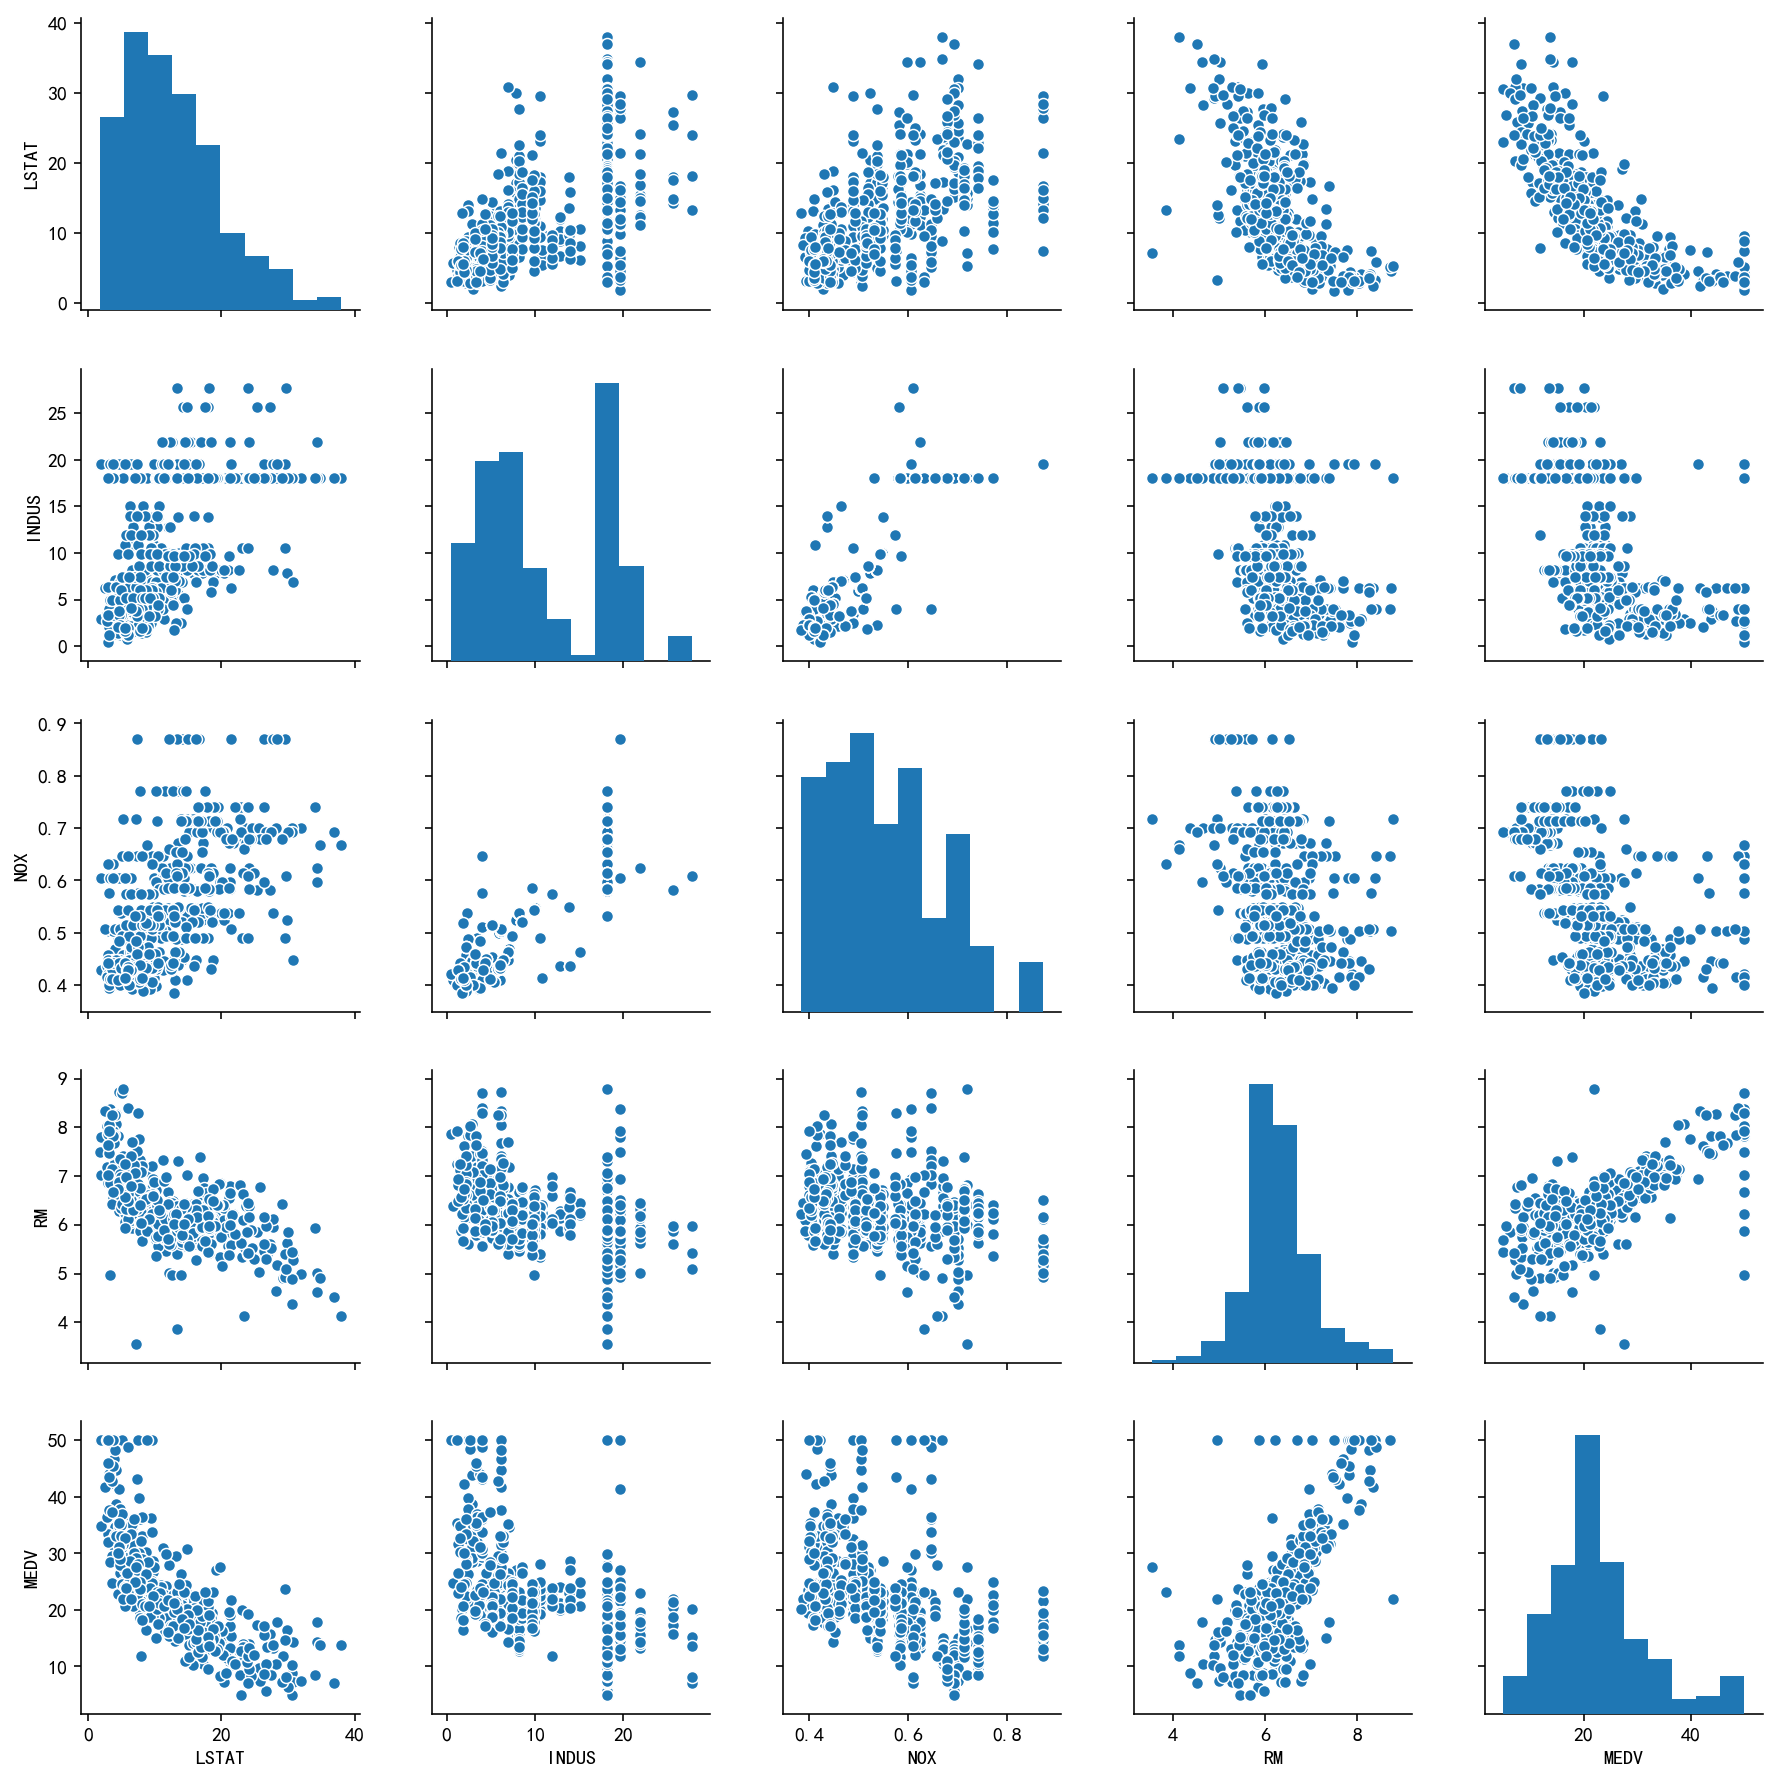

In [4]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

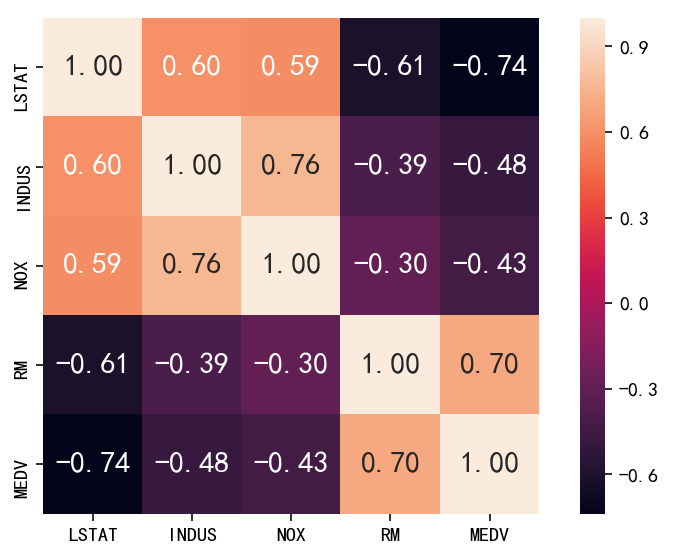

In [5]:
import numpy as np


cm = np.corrcoef(df[cols].values.T)
# sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

## 梯度下降法

+ 使用全部数据进行梯度下降。

In [6]:
class LinearRegressionGD:
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

只用 RM 这个特征。

In [7]:
X = df[['RM']].values
y = df['MEDV'].values

注意：**数据归一化对于线性回归是很重要的。**

In [8]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [9]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

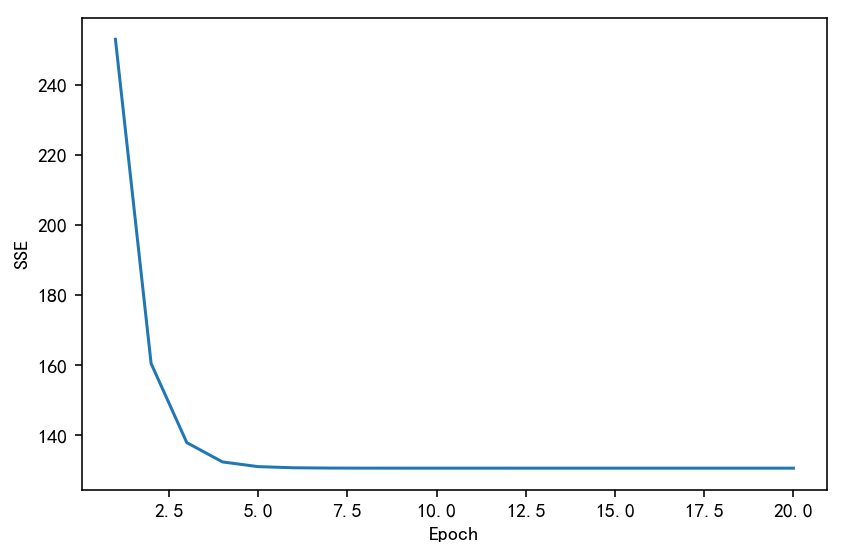

In [10]:
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [11]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return

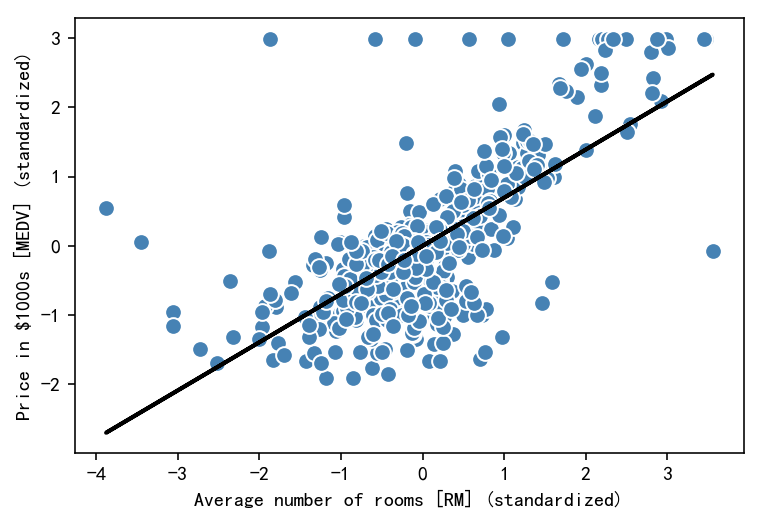

In [12]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

plt.show()

In [13]:
lr.w_[1]

0.6953594261783849

In [14]:
lr.w_[0]

-4.689582056016661e-16

In [17]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
price_std

array([-1.27262285])

In [16]:
sc_y.inverse_transform(price_std)

array([10.83993289])

## 使用 scikit-learn 的线性回归

这里没有标准化。

In [27]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression(normalize=True)
slr.fit(X, y)
y_pred = slr.predict(X)

In [28]:
slr.coef_[0]

9.10210898118031

In [29]:
slr.intercept_

-34.67062077643857

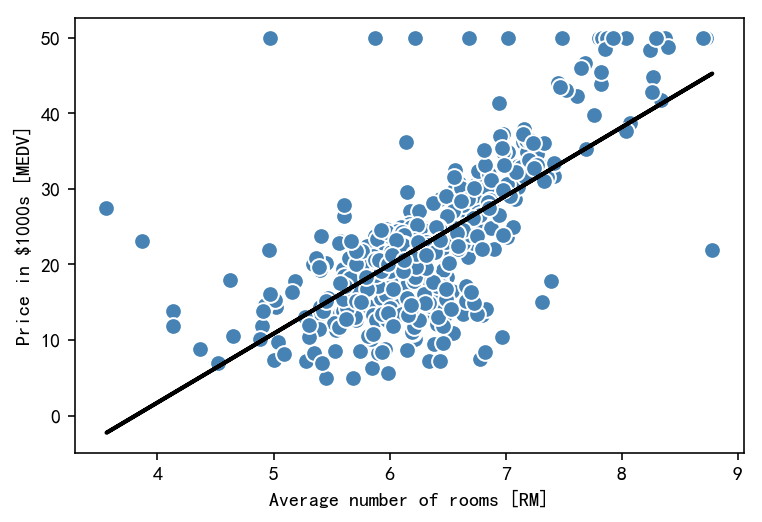

In [30]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

plt.show()

## 正规方程求解线性回归

In [31]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

In [32]:
w[1]

9.102108981179697

In [33]:
w[0]

-34.67062077643459

## 使用 RANSAC 拟合稳健的回归模型

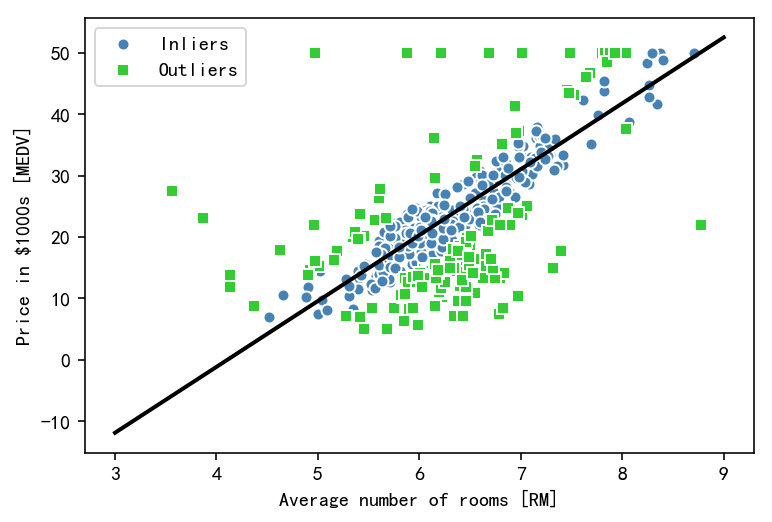

In [34]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=50,
    loss='absolute_loss',
    residual_threshold=5.0,
    random_state=0)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(
    X[inlier_mask],
    y[inlier_mask],
    c='steelblue',
    edgecolor='white',
    marker='o',
    label='Inliers')
plt.scatter(
    X[outlier_mask],
    y[outlier_mask],
    c='limegreen',
    edgecolor='white',
    marker='s',
    label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

plt.show()

## 评估线性回归模型的性能

In [36]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

In [37]:
X.shape

(506, 13)

In [38]:
y.shape

(506,)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [40]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

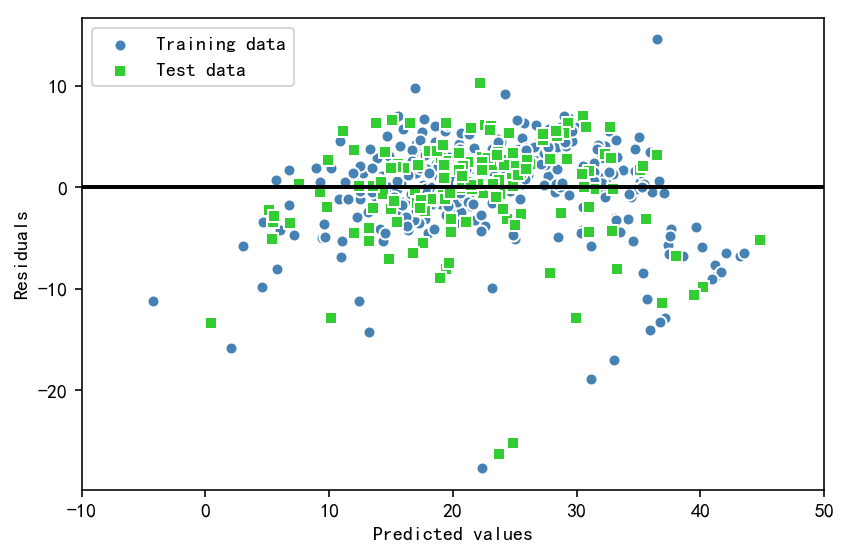

In [41]:
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='steelblue',
    marker='o',
    edgecolor='white',
    label='Training data')
plt.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='limegreen',
    marker='s',
    edgecolor='white',
    label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

In [42]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [43]:
mean_squared_error(y_train, y_train_pred)

19.958219814238046

In [44]:
mean_squared_error(y_test, y_test_pred)

27.195965766883354

In [45]:
r2_score(y_train, y_train_pred)

0.7645451026942549

In [46]:
r2_score(y_test, y_test_pred)

0.6733825506400177

过拟合了。

## 用正则化方法进行回归

In [47]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


In [48]:
mean_squared_error(y_train, y_train_pred)

20.92603097482835

In [49]:
mean_squared_error(y_test, y_test_pred)

28.875759467880663

In [50]:
r2_score(y_train, y_train_pred)

0.7531274572554778

In [51]:
r2_score(y_test, y_test_pred)

0.6532086050344972

In [52]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

In [53]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.0)

In [54]:
from sklearn.linear_model import ElasticNet

elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)